In [1]:
# To-Do: Create function that finds best prob_a cut-off-value.
# Use validation curve function.
import re
import os.path
import random
import pydotplus
from time import time
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import custom modules
import exploration
import preprocess
from predictions import Zero_Predictor, Average_Predictor

In [3]:
#ML imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn import tree

In [4]:
#Notebook commands
from IPython.display import Image  
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

## Tasks:

1. Read Data: For this assignment, assume input is CSV and write a function that can read a csv into python

2. Explore Data: You can use the code you wrote for assignment 1 here to generate distributions and data summaries.

3. Pre-Process Data: For this assignment, you can limit this to filling in missing values for the variables that have missing values. You can use any simple method to do it (use mean to fill in missing values).

4. Generate Features/Predictors: For this assignment, you should write one function that can discretize a continuous variable and one function that can take a categorical variable and create binary/dummy variables from it. Apply them to at least one variable each in this data.

5. Build Classifier: For this assignment, select any classifier you feel comfortable with (Logistic Regression for example)

6. Evaluate Classifier: you can use any metric you choose for this assignment (accuracy is the easiest one). Feel free to evaluate it on the same data you built the model on (this is not a good idea in general but for this assignment, it is fine). We haven't covered models and evaluation yet, so don't worry about creating validation sets or cross-validation. 

In [5]:
X_train, X_test, y_train, y_test = exploration.read_data_from_csv("data/credit-data.csv", 0, 
                                                                  True, "SeriousDlqin2yrs", 0.33)
data = X_train.join(y_train)
data.head()

,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
PersonID,,,,,,,,,,,,
87936,0.000000,68,60804,0,798.000000,NaN,4,0,1,0,0.0,0
3893,1.000000,34,60644,0,0.058946,4325.0,2,0,0,0,0.0,0
41405,1.000666,39,60637,0,1911.000000,NaN,5,0,2,0,0.0,0
91125,0.653085,52,60629,0,0.203020,4900.0,10,0,0,0,2.0,0
67373,1.000000,54,60625,3,779.000000,NaN,5,2,1,2,NaN,1


----
# Exploring data

In [6]:
# General description of data.
print("Dimension of train dataset: {} rows and {} features.\n".format(data.shape[0], data.shape[1]))
data.describe()

Dimension of train dataset: 100500 rows and 12 features.



,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
count,100500.000000,100500.000000,100500.000000,100500.000000,100500.000000,8.066300e+04,100500.000000,100500.000000,100500.000000,100500.000000,97874.000000,100500.000000
mean,5.459191,52.281841,60648.638239,0.435910,349.759787,6.637161e+03,8.457473,0.279174,1.018478,0.252667,0.759109,0.067393
std,210.022307,14.780930,56.640170,4.335404,1782.139436,1.193133e+04,5.141521,4.313026,1.120661,4.298975,1.118766,0.250703
min,0.000000,21.000000,60601.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029980,41.000000,60625.000000,0.000000,0.175145,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.155435,52.000000,60629.000000,0.000000,0.366655,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.560897,63.000000,60644.000000,0.000000,0.868521,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000,0.000000
max,29110.000000,109.000000,60804.000000,98.000000,307001.000000,1.794060e+06,57.000000,98.000000,32.000000,98.000000,13.000000,1.000000


In [7]:
# What is the distribution of our target variable?
data.SeriousDlqin2yrs.value_counts()
data.SeriousDlqin2yrs.value_counts(normalize=True)

0    93727
1     6773
Name: SeriousDlqin2yrs, dtype: int64

0    0.932607
1    0.067393
Name: SeriousDlqin2yrs, dtype: float64

We are trying to predict who experiences 90 days past due delinquency or worse. In our dataset, this only occurs in 6.6% of the cases.

60625    0.223662
60618    0.112209
60629    0.111731
60637    0.111711
60601    0.111055
60644    0.110100
60804    0.110100
60657    0.109433
Name: zipcode, dtype: float64

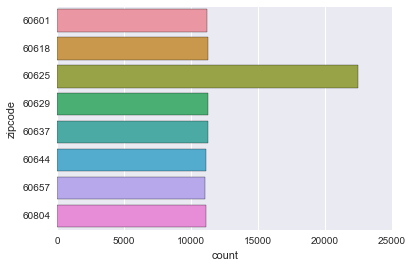

In [8]:
# Are ZIP codes equally represented?
data.zipcode.value_counts(normalize=True)
_ = sns.countplot(y="zipcode", data=data)

We only have data from 8 zip codes. The data looks equally distributed across zip codes, except for 60625 being responsible for 22% of the entries.

In [9]:
# How is our target variable distributed by ZIP code?
cross_table = pd.crosstab(data.zipcode, data.SeriousDlqin2yrs)
cross_table["total"] = cross_table[0] + cross_table[1]
cross_table["perc_of_SeriousDlqin2yrs"] = cross_table[1] / cross_table["total"]
cross_table

SeriousDlqin2yrs,0,1,total,perc_of_SeriousDlqin2yrs
zipcode,,,,
60601,10424,737,11161,0.066034
60618,10530,747,11277,0.066241
60625,20969,1509,22478,0.067132
60629,10502,727,11229,0.064743
60637,10469,758,11227,0.067516
60644,10294,771,11065,0.069679
60657,10250,748,10998,0.068012
60804,10289,776,11065,0.070131


While the ZIP code 60625 has the most entries in the dataset, the relative rate of individuals experiencing 90 days past due delinquency or worse is relatively stable across all ZIP codes.

In [10]:
# What is the mean of a variable for target = 1 and target = 0?
data.groupby("SeriousDlqin2yrs").mean()

,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,,,,,,,,,,,
0,5.574359,52.747415,60648.569164,0.284262,353.424513,6716.737005,8.497786,0.136684,1.020656,0.128159,0.746169
1,3.865456,45.839067,60649.594124,2.534475,299.046113,5581.459851,7.899601,2.250997,0.988336,1.975639,0.936673


On average, individuals experiencing 90 days past due delinquency or worse ...
    - are younger (45.8 vs 52.75)
    - have a lower income (5581 vs 6716)
    - have a lower debt ratio (299 vs 353). However, these means are likely influenced by outliers or come from cases without monthly income/ with no reported income. Therefore, this comparison only holds if we assume that no income/no reported income shows same distribution across target variable.
    - have a lower amount of open credit lines and loans (7.89 vs 8.5)
    - have more dependents (0.94 vs 0.75)
    - have been more often 30-59/60-89/90 days past due but no worse in the last 2 years.

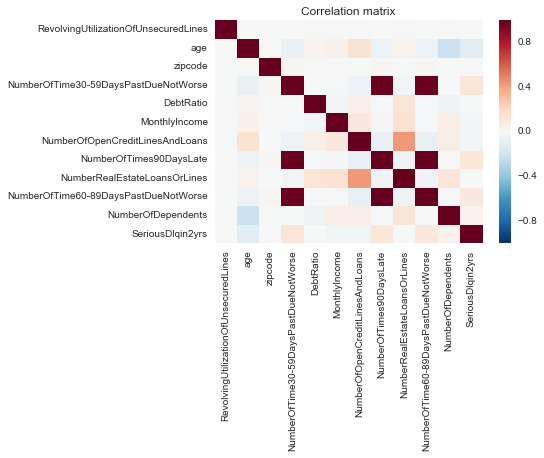

In [11]:
# How are the variables correlated with each other?
exploration.plot_correlations(data, 'Correlation matrix')

_Answer:_ 

There is a __moderate__ positive correlation between our target variable _SeriousDlqin2yrs_ and:
    - NumberOfTime30-59DaysPastDueNotWorse
    - NumberOfTime60-89DaysPastDueNotWorse
    - NumberOfTime90DaysLate
    
There is a __small__ positive correlation between our target variable _SeriousDlqin2yrs_ and:
    - NumberOfDependents
   
There is a __small__ negative correlation between our target variable _SeriousDlqin2yrs_ and:
    - age

----
# Pre-Processing

In [12]:
data.head()

,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
PersonID,,,,,,,,,,,,
87936,0.000000,68,60804,0,798.000000,NaN,4,0,1,0,0.0,0
3893,1.000000,34,60644,0,0.058946,4325.0,2,0,0,0,0.0,0
41405,1.000666,39,60637,0,1911.000000,NaN,5,0,2,0,0.0,0
91125,0.653085,52,60629,0,0.203020,4900.0,10,0,0,0,2.0,0
67373,1.000000,54,60625,3,779.000000,NaN,5,2,1,2,NaN,1


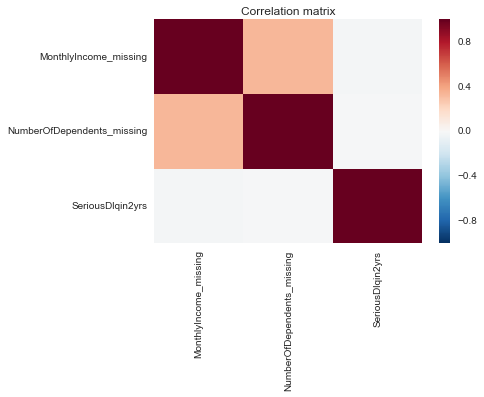

In [13]:
new_columns = preprocess.keep_track_of_missing_values(data, "_missing")
data = preprocess.fill_missing_values_with_mean(data)

#Are the missing values correlated with our target?
exploration.plot_correlations(data[new_columns + ["SeriousDlqin2yrs"]], 'Correlation matrix')

There is no correlation between missing values and our target _SeriousDlqin2yrs_.

----
# Building Features

In [14]:
# setting test's zipcode as category with attributes from train to ensure 
# same columns in train and test set.
X_test["zipcode"] = X_test["zipcode"].astype('category', categories=X_train.zipcode.unique())

# We will use this code to identify discretized dummy vars
dummy_code = "_XX_disc"

# modifying variables
data = preprocess.dummify_var(data, ["zipcode"])
data = preprocess.discretize_cont_var(data, "age", 10, dummy_code)

----
# Preprocessing Test Set

In [15]:
#We will use the preprocessed data as training data
X_train = data.drop(["SeriousDlqin2yrs"], axis=1)

In [16]:
# Do we have similar % of target in train and test?
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

0    0.932607
1    0.067393
Name: SeriousDlqin2yrs, dtype: float64

0    0.934283
1    0.065717
Name: SeriousDlqin2yrs, dtype: float64

In [17]:
# ensuring that X_test has the same columns as X_train
X_test = preprocess.dummify_var(X_test, ["zipcode"])
col_to_value_dict = preprocess.build_col_to_value_dict(X_train, dummy_code)
X_test = preprocess.insert_discretize_quantiles(X_test, col_to_value_dict)

#keeping track of missing values (but only in same columns as train data)
preprocess.create_missing_value_colum_in_testset(X_train, X_test, "_missing")

#fill empty values
X_test = preprocess.fill_missing_values_with_mean(X_test)

----
# Training Classifier

In [18]:
# Source:
# http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html#sphx-glr-auto-examples-model-selection-randomized-search-py
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [19]:
# It is unlikely that an individual is delinquent. 
# How well can we predict if we randomly predict 
# according to mean of training data?
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, 
                                                                    test_size=0.3, random_state=0)
AvgPred = Average_Predictor()
AvgPred.fit(y_train_val)
AvgPred.score(X_test_val, y_test_val)

0.87492537313432839

When we only predict that an individual is delinquent according to the probability of delinquency (predict delinquency when random number is less than mean of y_train_val), we achieve an accuracy of 0.87 on our hold-out set from the training data.

In [20]:
# It is unlikely that an individual is delinquent. 
# How well can we predict if we always predict non-delinquent?

ZeroPred = Zero_Predictor()
ZeroPred.score(X_test_val, y_test_val)

0.93429519071310119

When we always predict that an individual is delinquent, we achieve an accuracy of 0.933 on our hold-out set from the training data.

In [21]:
# Training Random Forest with grid search
rf_pickle_file_name = 'grid_search_rf.pkl'
want_to_retrain = False

if os.path.isfile(rf_pickle_file_name) and (not want_to_retrain):
    grid_search = joblib.load(rf_pickle_file_name) 

else:
    clf = RandomForestClassifier(n_estimators=40, n_jobs=-1)

    # use a full grid over all parameters
    param_grid = {"max_features": np.arange(0.1, 1, 0.1),
                  "min_samples_leaf": [1, 3, 10]}

    # run grid search; default k cross validation is 3
    grid_search = GridSearchCV(clf, param_grid=param_grid)

    start = time()
    grid_search.fit(X_train, y_train)

    print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
          % (time() - start, len(grid_search.cv_results_['params'])))

    joblib.dump(grid_search, rf_pickle_file_name) 

In [22]:
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.936 (std: 0.001)
Parameters: {'min_samples_leaf': 10, 'max_features': 0.30000000000000004}

Model with rank: 2
Mean validation score: 0.936 (std: 0.001)
Parameters: {'min_samples_leaf': 10, 'max_features': 0.40000000000000002}

Model with rank: 3
Mean validation score: 0.936 (std: 0.001)
Parameters: {'min_samples_leaf': 10, 'max_features': 0.5}



We identified the best-performing random forest configuration through grid search. It has the parameters 'min_samples_leaf' = 10 and only max. 30% of all features are used when deciding on which variable to split next. It achieves a score of 0.936 - only slighlty higher than the score we achieved when always predicting that an individual is not delinquent.

In [23]:
# Let's take a look at our differences.
predictions = grid_search.predict(X_train)

#What was the average vote for class 1?
predictions_prob = grid_search.predict_proba(X_train)[:,1]

errors = np.absolute(predictions - np.asarray(y_train))
errors_prob = np.absolute(predictions_prob - np.asarray(y_train))

prediction_comp = pd.DataFrame({'prediction': predictions,
                                'predictions_prob': predictions_prob,
                                'true_y': y_train,
                                'errors': errors,
                                'errors_prob': errors_prob})
prediction_comp[prediction_comp.errors == 1][["prediction", "predictions_prob", 
                                              "true_y", "errors_prob"]].head(100)

,prediction,predictions_prob,true_y,errors_prob
PersonID,,,,
16948,0,0.415944,1,0.584056
76699,1,0.505759,0,0.505759
77501,0,0.408133,1,0.591867
119903,0,0.306692,1,0.693308
15928,0,0.402443,1,0.597557
61178,0,0.073134,1,0.926866
69548,0,0.384750,1,0.615250
74734,0,0.190880,1,0.809120
131545,0,0.138156,1,0.861844


In [24]:
# What is the best cut-off value for our prob_a?
dec_tree = tree.DecisionTreeClassifier()
fitted_tree = dec_tree.fit(prediction_comp.predictions_prob.values.reshape(-1,1), prediction_comp.true_y)

fitted_tree.score(prediction_comp.predictions_prob.values.reshape(-1,1), prediction_comp.true_y)

#What is the threshold for the first split?
fitted_tree.tree_.threshold[0]

0.99943283582089548

0.17080429196357727

In [25]:
threshold = 0.17080429196357727
prediction_comp["pred_w_threshold"] = prediction_comp.predictions_prob.apply(lambda x: 0 if x < threshold else 1)
prediction_comp.head(10)

,errors,errors_prob,prediction,predictions_prob,true_y,pred_w_threshold
PersonID,,,,,,
87936,0,0.001095,0,0.001095,0,0
3893,0,0.054830,0,0.054830,0,0
41405,0,0.033940,0,0.033940,0,0
91125,0,0.069066,0,0.069066,0,0
67373,0,0.214981,1,0.785019,1,1
89595,0,0.022370,0,0.022370,0,0
77733,0,0.138508,0,0.138508,0,0
119526,0,0.016485,0,0.016485,0,0
1789,0,0.024956,0,0.024956,0,0


In [26]:
len(prediction_comp[prediction_comp.true_y == prediction_comp.pred_w_threshold]) / len(prediction_comp)

0.9234228855721393

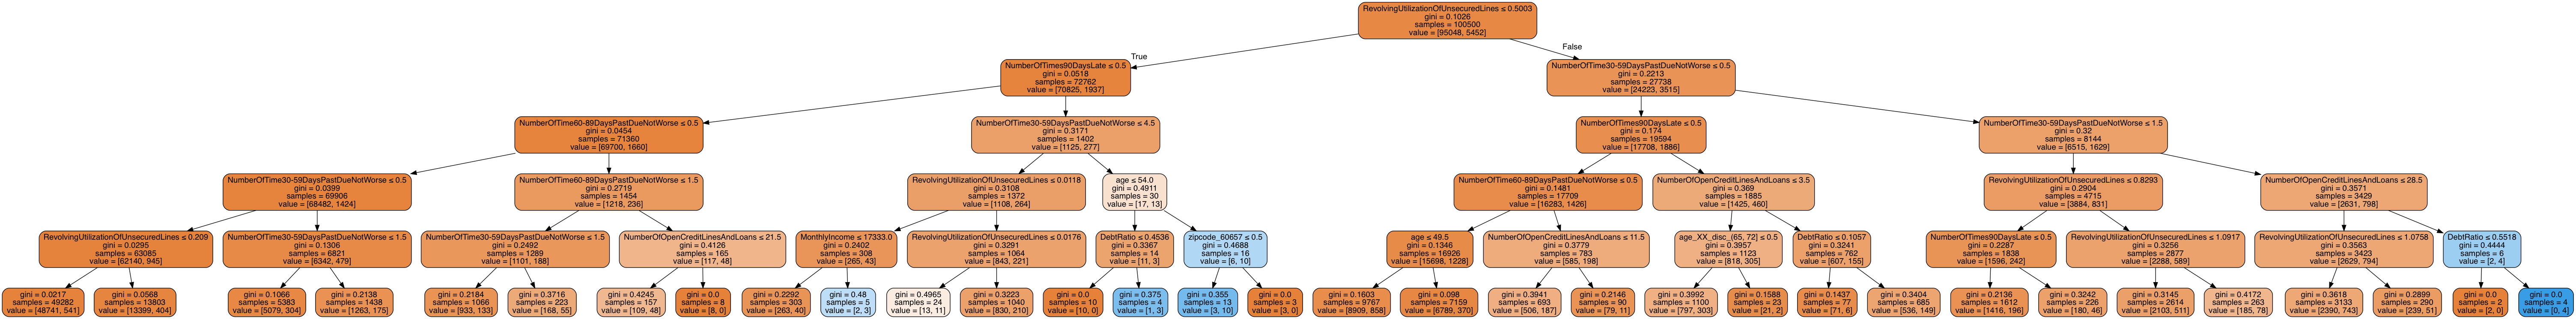

In [30]:
# Can we better understand our errors?
dec_tree = tree.DecisionTreeClassifier(max_depth=5)
fitted_tree = dec_tree.fit(X_train, prediction_comp.errors)

#Source: http://scikit-learn.org/stable/modules/tree.html
dot_data = tree.export_graphviz(fitted_tree, out_file=None, 
                         feature_names=X_train.columns,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [ ]:
#How well do we do on the test set?
grid_search.score(X_test, y_test)